<a href="https://colab.research.google.com/github/ra4ola/APA-Assigment2/blob/main/Parte%201/Parte1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
from torch.nn.modules.flatten import Flatten
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import os
from google.colab import drive
import torch.nn.functional as F

# Mount Drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


# Definição de Variáveis

In [3]:
PATH = '/content/drive/MyDrive/APA/Assigment2/Parte3'

In [4]:
image_size = 28
lr = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)

# Modelos


In [18]:
# @title AE

class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        self.encoder = nn.Sequential(

            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(8),
            nn.ELU(),

            nn.Conv2d(in_channels=8, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ELU(),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ELU(),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ELU(),

            nn.Conv2d(in_channels=128, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ELU()
        )
        self.decoder = nn.Sequential(

         nn.ConvTranspose2d(in_channels=16, out_channels=128, kernel_size=3, stride=1, padding=1),
         nn.BatchNorm2d(128),
         nn.ELU(),

         nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1),
         nn.BatchNorm2d(64),
         nn.ELU(),

         nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1),
         nn.BatchNorm2d(32),
         nn.ELU(),

         nn.ConvTranspose2d(in_channels=32, out_channels=8, kernel_size=3, stride=1, padding=1),
         nn.BatchNorm2d(8),
         nn.ELU(),

         nn.Upsample(scale_factor=2, mode='nearest'),  # Upsample
         nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=3, stride=1, padding=1),
         nn.BatchNorm2d(1),
         nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [63]:
# @title VAE
class VAE(nn.Module):
    def __init__(self):
      super(VAE, self).__init__()
      self.encoder = nn.Sequential(
          nn.Conv2d(1, 8, 3, 2, 1),
          nn.BatchNorm2d(8),
          nn.ELU(inplace=True),

          nn.Conv2d(8, 32, 3, 1, 1),
          nn.BatchNorm2d(32),
          nn.ELU(inplace=True),

          nn.Conv2d(32, 64, 3, 1, 1),
          nn.BatchNorm2d(64),
          nn.ELU(inplace=True),

          nn.Conv2d(64, 128, 3, 1, 1),
          nn.BatchNorm2d(128),
          nn.ELU(inplace=True),
        )

      self.mean_layer = nn.Linear(128 * (image_size // 2) ** 2, 16)

      self.logvar_layer = nn.Linear(128 * (image_size // 2) ** 2, 16)

      self.decoder_fc = nn.Linear(16, 128 * (image_size // 2) ** 2)


      self.decoder = nn.Sequential(

          nn.ConvTranspose2d(16, 128, 3, 1, 1),
          nn.BatchNorm2d(128),
          nn.ELU(inplace=True),

          nn.ConvTranspose2d(128, 64, 3, 1, 1),
          nn.BatchNorm2d(64),
          nn.ELU(inplace=True),

          nn.ConvTranspose2d(64, 32, 3, 1, 1),
          nn.BatchNorm2d(32),
          nn.ELU(inplace=True),

          nn.ConvTranspose2d(32, 8, 3, 1, 1),
          nn.BatchNorm2d(8),
          nn.ELU(inplace=True),

          #nn.Upsample(scale_factor=2, mode='nearest'),
          nn.ConvTranspose2d(8, 1, 3, 1, 1),
          nn.BatchNorm2d(1),
          nn.Sigmoid()
        )

    def forward(self, x):
      x = self.encoder(x)
      print(x.shape)
      x = x.view(x.size(0), -1)
      mean, logvar = self.mean_layer(x), self.logvar_layer(x)
      epsilon = torch.randn_like(torch.exp(0.5 * logvar)).to(device)
      x = mean + logvar*epsilon
      x = self.decoder_fc(x)
      x = x.view(x.size(0), 16, (image_size // 2), (image_size // 2))
      print(x.shape)
      x = self.decoder(x)
      return x, mean, logvar



## DAE

In [7]:
# @title DAE

class DAE(nn.Module):
    def __init__(self):
      super(DAE, self).__init__()
      self.encoder = AE()

    def forward(self, x):
      x = self.encoder(x)
      return x

# Definição de Funções

### Funções de Construção das String para os Caminhos

In [8]:
def ModelDirStr(modelName,path = PATH):
  return f"{path}/{modelName}"
def pathModelStr(modelName,epoch, path = PATH):
  return f"{ModelDirStr(modelName,path)}/{modelName}_epoch={epoch}"

### Função para adicionar Noise

In [9]:
# @title Noise Fuction DAE

def add_noise(data, noise_factor=0.5):
    noisy_data = data + noise_factor * torch.randn_like(data)
    return torch.clamp(noisy_data, 0., 1.)




### Função de Treino


In [10]:
# @title Train Fuction

def train(model, criterion, optimizer, train_loader, epochs, modelName, scheduler=None, path=PATH):
    os.makedirs(ModelDirStr(modelName=modelName, path=path), exist_ok=True)

    for epoch in range(epochs):
        model.train()  # Set the model to training mode

        epoch_loss = 0

        for inputs, _ in train_loader:
            inputs = inputs.to(device)
            optimizer.zero_grad()

            if isinstance(model, VAE):
                outputs, mean, log_var = model(inputs)
                reconstruction_loss = criterion(outputs, inputs)
                kld_loss = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
                loss = reconstruction_loss + kld_loss
            else:
                outputs = model(inputs)
                loss = criterion(outputs, inputs)

            loss.backward()
            optimizer.step()

            epoch_loss = epoch_loss =+ loss.item()

        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")

        if scheduler is not None:
            scheduler.step()

        torch.save(model, pathModelStr(modelName=modelName, path=path, epoch=epoch))


### Função de Implementação das Perdas

In [11]:
# @title Evalute Training

def evaluate_training(training_loader, loss_fn, num_epochs, modelName, path=PATH):
    all_losses = []
    all_kl_loss = []

    # Load the model outside the epoch loop


    for epoch in range(num_epochs):
        running_loss = 0.0
        running_kld = 0.0
        model_path = pathModelStr(modelName=modelName, path=path, epoch=epoch)
        model = torch.load(model_path).to(device)

        model.eval()

        with torch.no_grad():
            for batch in training_loader:
                inputs, targets = batch
                inputs = inputs.to(device)

                if isinstance(model, VAE):
                    outputs, mean, log_var = model(inputs)
                    reconstruction_loss = loss_fn(outputs, inputs)
                    kld_loss = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
                    loss = reconstruction_loss + kld_loss
                else:
                    outputs = model(inputs)
                    loss = loss_fn(outputs, inputs)

                running_loss += loss.item()
                running_kld += kld_loss.item() if isinstance(model, VAE) else 0

        all_losses.append(running_loss)
        all_kl_loss.append(running_kld)

        print(f'Epoch {epoch}: Epoch Loss: {running_loss/len(train_loader):.4f}, KL Divergence: {running_kld:.4f}')

    return all_losses, all_kl_loss



### Função Display Images

In [12]:
# @title Plot Losses

def plot_loss_accuracy(losses, Tittle = 'Traning Loss', curve_Label = 'Loss',X_axis_label = 'Epochs', Y_axis_Label = 'Loss'):
    epochs = range(1, len(losses) + 1)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, losses, 'b', label=curve_Label)
    plt.title(Tittle)
    plt.xlabel(X_axis_label)
    plt.ylabel(Y_axis_Label)
    plt.legend()

    plt.tight_layout()
    plt.show()

In [13]:
# @title Image Reconstruction

def reconstruction_images_plot(model,test_loader, Title = 'Reconstruction'):
  with torch.no_grad():
    for data in test_loader:
      inputs, _ = data
      inputs = inputs.to(device)

      outputs = model(inputs)

      n = 10
      plt.figure(figsize=(20, 4))
      plt.title = Title
      for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(inputs[i].cpu().view(28, 28).numpy(), cmap='gray')
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(outputs[i].cpu().view(28, 28).numpy(), cmap='gray')
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

      plt.show()
      break

# Importação do DataSet

In [14]:
# @title DataSet Import

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 237967118.71it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 39215180.91it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 86164300.27it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 3705607.62it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Implementação dos Modelos

## Inicialização do Modelo

In [22]:
# @title AE Initialization

epochs = 3
ae = AE().to(device)

criterion = nn.MSELoss()


optimizerAE = optim.Adam(ae.parameters(), lr = lr)

## AE Treino

In [23]:
# @title Treino AE
train(
    model = ae,
    criterion = criterion,
    optimizer = optimizerAE,
    train_loader = train_loader,
    epochs = epochs,
    modelName = "AE",
    scheduler=None,
    path = PATH
  )

Epoch [1/3], Loss: 1.3626
Epoch [2/3], Loss: 1.1567
Epoch [3/3], Loss: 1.0693


In [24]:
# @title AE Losses Calculation

loss,_ =evaluate_training(
    training_loader = train_loader,
    loss_fn = criterion,
    num_epochs = epochs,
    modelName = "AE",
    path = PATH
    )


Epoch 0: Epoch Loss: 1.3645, KL Divergence: 0.0000
Epoch 1: Epoch Loss: 1.1810, KL Divergence: 0.0000
Epoch 2: Epoch Loss: 1.0676, KL Divergence: 0.0000


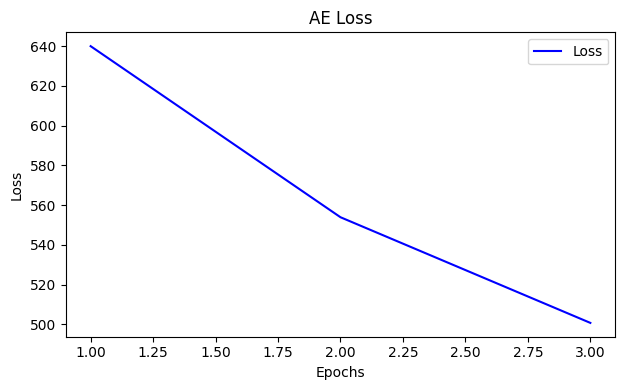

In [25]:
# @title AE Plot Losses
plot_loss_accuracy(losses = loss, Tittle = 'AE Loss')

## DAE Treino

In [26]:
# @title DAE Initialization

dae = DAE().to(device)

optimizerDAE = optim.Adam(dae.parameters(), lr = lr)

In [27]:
# @title Treino DAE

train(
    model = dae,
    criterion = criterion,
    optimizer = optimizerDAE,
    train_loader = train_loader,
    epochs = epochs,
    modelName = "DAE",
    scheduler=None,
    path = PATH
  )

Epoch [1/3], Loss: 1.3677
Epoch [2/3], Loss: 1.1871
Epoch [3/3], Loss: 1.0797


In [28]:
# @title DAE Losses Calculation

loss,_ =evaluate_training(
    training_loader = train_loader,
    loss_fn = criterion,
    num_epochs = epochs,
    modelName = "DAE",
    path = PATH
  )

Epoch 0: Epoch Loss: 1.3624, KL Divergence: 0.0000
Epoch 1: Epoch Loss: 1.1793, KL Divergence: 0.0000
Epoch 2: Epoch Loss: 1.0681, KL Divergence: 0.0000


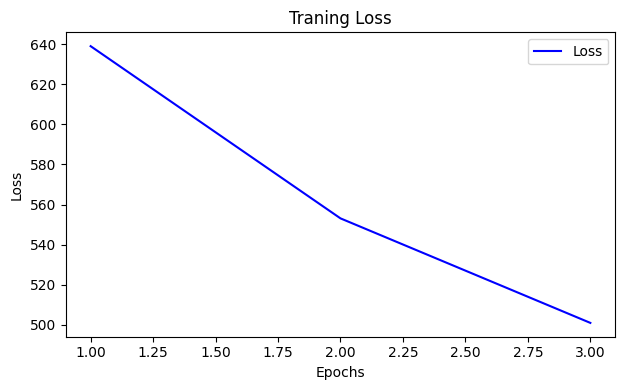

In [29]:
# @title DAE Plot Losses
plot_loss_accuracy(losses = loss)

## VAE Treino

In [38]:
# @title Initialization VAE
vae = VAE().to(device)

optimizerVAE = optim.Adam(vae.parameters(), lr = lr)

In [39]:
# @title VAE Treino

train(
    model = vae,
    criterion = criterion,
    optimizer = optimizerVAE,
    train_loader = train_loader,
    epochs = epochs,
    modelName = "VAE",
    scheduler=None,
    path = PATH
  )

TypeError: ignored

In [ ]:
# @title VAE Calculate Losses

loss,kld_loss =evaluate_training(
    training_loader = train_loader,
    loss_fn = criterion,
    num_epochs = epochs,
    modelName = "VAE",
    path = PATH
  )

In [ ]:
# @title DAE Plot Losses

plot_loss_accuracy(losses= loss)

In [ ]:
# @title Reconstrução das Imagens
reconstruction_images_plot(dae,test_loader)

# Latent Space

In [ ]:
# @title Latent Space Calculation  and Plot Fuction
def extract_latent_space_and_labels_with_tsne(model, training_loader, device):
    latent_space = []
    labels = []

    with torch.no_grad():
        for batch_idx, data in enumerate(training_loader):
            model.eval()
            mu = model.encode(data[0].to(device))
            latent_space.append(mu)
            labels.append(data[1])

    latent_space = torch.cat(latent_space, dim=0).cpu().numpy()
    labels = torch.cat(labels, dim=0).cpu().numpy()

    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    latent_tsne = tsne.fit_transform(latent_space)

    # Plot the t-SNE visualization
    plt.scatter(latent_tsne[:, 0], latent_tsne[:, 1], c=labels, cmap='viridis')
    plt.colorbar()
    plt.title("t-SNE Visualization of Latent Space")
    plt.show()

    return latent_space, labels, latent_tsne

In [ ]:
latent_spaceae, labelsae, latent_tsneae = extract_latent_space_and_labels_with_tsne(ae, train_loader, device)

In [ ]:
latent_spacedae, labelsdae, latent_tsnedae = extract_latent_space_and_labels_with_tsne(dae, training_loader, device)

In [ ]:
latent_spacedvae, labelsvae, latent_tsnevae = extract_latent_space_and_labels_with_tsne(vae, training_loader, device)